In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere
from math import sqrt, pi, acos, floor, log2, ceil, gcd
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from random import randint
from fractions import Fraction
from qiskit.providers.ibmq import least_busy
import time

In [2]:
def sSim(circuit, shots = 256, draw=True):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub = 'ibm-q' , group = 'open' , project = 'main')
    simulator = provider.get_backend('simulator_mps')
    job = execute(circuit, simulator, shots = shots)
    result = job.result()
    counts = result.get_counts()
    if draw:
        print(counts)
        display(plot_histogram(counts))
    return counts

def rSim(circuit, shots = 256, draw=True):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub = 'ibm-q' , group = 'open' , project = 'main')
    qcomp = provider.get_backend('ibmq_manila')
    job = execute(circuit , backend = qcomp , shots = shots)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(circuit)
    if draw:
        print(counts)
        display(plot_histogram(counts))
    return counts
    
def b2d(counts,signed = True):
    max_key = max(counts, key=lambda key: counts[key])
    num = int(max_key,2)
    n = len(max_key)
    if max_key[0] == '1' and signed:
        return num - 2**n
    else: return num

In [3]:
def initnum(a,n):
    U = QuantumCircuit(n)
    bitArr = []
    q = a
    for i in range(n):
        if q%2==1: U.x(i)
        q = q//2
    U = U.to_gate()
    U.name = "Init(%i)" % a
    return U

def ADD(a,n,ctrl=0,draw=False):
    U = QuantumCircuit(n)
    bitArr = []
    q = a
    for i in range(n):
        bitArr.append(q%2)
        q = q//2
    bBitArr = [0]*n
    for bi in range(n):
        for ai in range(bi+1):
            k = (bi+1-ai)
            if bitArr[ai]==1: bBitArr[bi] += 2**(-k)
    for bi in range(n):
        U.rz(2*pi*bBitArr[bi],n-1-bi)
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "ADD(%i)" % a
    if ctrl==0:
        return U
    else:
        return U.control(ctrl)
    

def ADD_dagger(a,n,ctrl=0, draw=False):
    U = QuantumCircuit(n)
    bitArr = []
    q = a
    for i in range(n):
        bitArr.append(q%2)
        q = q//2
    bBitArr = [0]*n
    for bi in range(n):
        for ai in range(bi+1):
            k = (bi+1-ai)
            if bitArr[ai]==1: bBitArr[bi] += 2**(-k)
    for bi in range(n):
        U.rz(-2*pi*bBitArr[bi],n-1-bi)
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "ADD_D(%i)" % a
    if ctrl==0:
        return U
    else:
        return U.control(ctrl)

# QFT
def qft(n):
    """n-qubit QFT the first n qubits in circuit"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT"
    return qc.to_gate()

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circuit"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFTD"
    return qc.to_gate()

def add_mod(a,N,n, draw=False): #n=n+1
    U = QuantumCircuit(n+3)
    c1 = n
    c2 = n+1
    ctrl = n+2
    U.append( ADD(a,n,2), [c1,c2] + list(range(n)) )
    U.append( ADD_dagger(N,n), range(n) )
    U.append( qft_dagger(n), range(n) )
    U.cx( n-1, ctrl )
    U.append( qft(n), range(n) )
    U.append( ADD(N,n,1), [ctrl]+list(range(n)) )
    U.append( ADD_dagger(a,n,2), [c1,c2] + list(range(n)) )
    U.append( qft_dagger(n), range(n) )
    U.x(n-1)
    U.cx( n-1, ctrl )
    U.x(n-1)
    U.append( qft(n), range(n) )
    U.append( ADD(a,n,2), [c1,c2] + list(range(n)) )
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "ADD(%i)mod(%i)" % (a,N)
    return U

def add_mod_dagger(a,N,n, draw=False): #n=n+1
    U = QuantumCircuit(n+3)
    c1 = n
    c2 = n+1
    ctrl = n+2
    U.append( ADD_dagger(a,n,2), [c1,c2] + list(range(n)) )
    U.append( qft_dagger(n), range(n) )
    U.x(n-1)
    U.cx( n-1, ctrl )
    U.x(n-1)
    U.append( qft(n), range(n) )
    U.append( ADD(a,n,2), [c1,c2] + list(range(n)) )
    U.append( ADD_dagger(N,n,1), [ctrl]+list(range(n)) )
    U.append( qft_dagger(n), range(n) )
    U.cx( n-1, ctrl )
    U.append( qft(n), range(n) )
    U.append( ADD(N,n), range(n) )
    U.append( ADD_dagger(a,n,2), [c1,c2] + list(range(n)) )
    
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "ADD(%i)mod(%i)\'" % (a,N)
    return U

def cmult_mod(a,N,n, draw=False):
    U = QuantumCircuit(2*n+3)
    ctrl = 0
    x = range(1,n+1)
    b = range(n+1,2*n+2)
    additional_bit = 2*n+2
    U.append( qft(n+1), b )
    for i in range(n):
        sub_a = (a*2**i)%N
        U.append( add_mod(sub_a,N,n+1), list(b)+[ctrl, x[i], additional_bit] )
    U.append( qft_dagger(n+1), b )
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "cmult(%i)mod(%i)" % (a,N)
    return U

def cmult_mod_dagger(a,N,n, draw=False):
    U = QuantumCircuit(2*n+3)
    ctrl = 0
    x = range(1,n+1)
    b = range(n+1,2*n+2)
    additional_bit = 2*n+2
    U.append( qft(n+1), b )
    for i_v in range(n):
        i = n-1-i_v
        sub_a = (a*2**i)%N
        U.append( add_mod_dagger(sub_a,N,n+1), list(b)+[ctrl, x[i], additional_bit] )
    U.append( qft_dagger(n+1), b )
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "cmult(%i)mod(%i)\'" % (a,N)
    return U

def U_a(a,N,n,draw=False,power=1):
    U = QuantumCircuit(2*n+3)
    if (gcd(a,N)!=1): raise Exception('a and N should be coprime')
    a_true = a**power
    U.append( cmult_mod(a_true,N,n), range(2*n+3) )
    for i in range(n):
        U.cswap(0,i+1,i+1+n)
    a_inv = 0
    a_inv = modinv(a_true , N)
    print(a_inv)
    U.append( cmult_mod_dagger(a_inv,N,n), range(2*n+3) )
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = " %i^%i mod(%i)" % (a,power,N)
    return U

## -----finding modular inverse-----
def egcd(a , b):
    if a == 0:
        return (b , 0 , 1)
    else:
        g , y , x = egcd(b % a , a)
        return (g , x - (b // a) * y , y)
def modinv(k , n):
    g , x , y = egcd(k , n)
    return x % n
## -----finding modular inverse-----

def shor(a,N,n,draw=False):
    m = ceil(log2(N**2))
    U = QuantumCircuit(m+2*n+2,2*n)
    
    ### build main func
    p1 = range(m)
    p2 = range(m,m+n)
    p3 = range(m+n,m+2*n)
    for i in p1:
        U.h(i)
    U.append(initnum(1,n),p2)
    U.append(initnum(0,n),p3)
    for i in p1:
        U.append( U_a(a,N,n,power=2**i), [i]+list(range(m,m+2*n+2)) )
    U.append(qft_dagger(len(p1)),p1)
    U.measure(p1,p1)
    if draw: display(U.draw(output='mpl'))
    return sSim(U)

def findP(N):
    if N%2==0: return 2
    count = 0
    while count<100:
        count+=1
        print('test #%i'%count)
        a = randint(2 , N - 1)
        if gcd(a,N)>1:
            print('find by gcd')
            return gcd(a,N)
        print('guess a=%i'%a)
        n = ceil(log2(N))
        counts = shor(a,N,n,True)
        rows, measured_phases = [], []
        for output in counts:
            decimal = int(output, 2) # Convert (base 2) string to decimal
            phase = decimal/(2**ceil(log2(N**2))) # Find corresponding eigenvalue
            measured_phases.append(phase)
        for phase in measured_phases:
            frac = Fraction(phase).limit_denominator(N)
            d = frac.denominator
            if(d%2==0):
                g1 = a**(d//2)-1
                g2 = a**(d//2)+1
                if g2%N!=0:
                    gcd1 = gcd(g1,N)
                    gcd2 = gcd(g2,N)
                    if gcd1>1 or gcd2>1:
                        print('period =',d)
                        gc = max(gcd1,gcd2)
                        print('%i = %i*%i'%(N,gc,N//gc))
                        return gc
        print('a!=%i'%a)

test #1
guess a=7
13


C:\Users\user\AppData\Local\Temp/ipykernel_10792/75432271.py:66: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(np.pi/float(2**(j-m)), m, j)


4
1
1
1
1
1
1


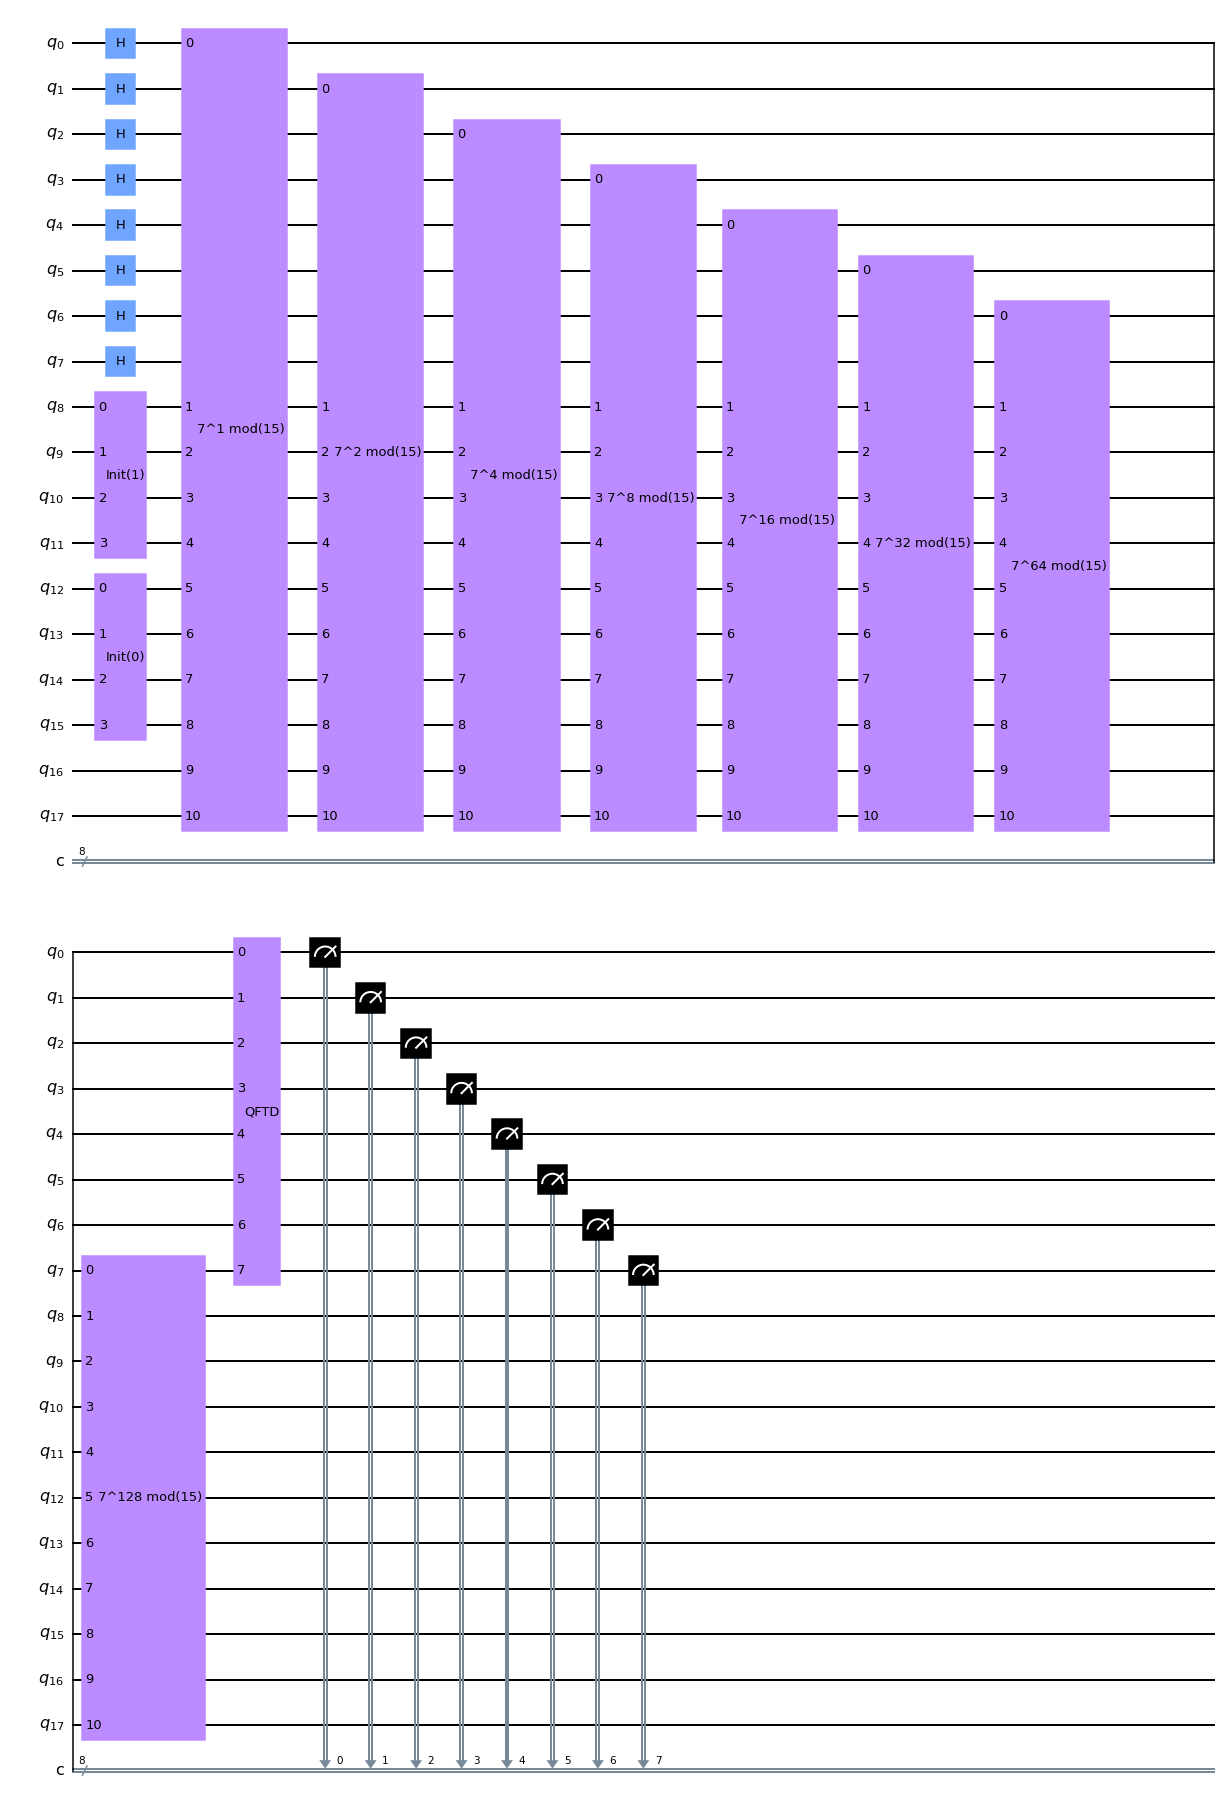

{'00000000': 72, '01000000': 68, '10000000': 66, '11000000': 50}


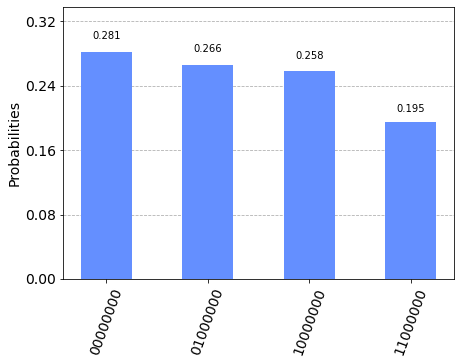

period = 4
15 = 5*3
time =  79.27157354354858


In [5]:
time_start = time.time()
findP(15)
time_end = time.time()
print("time = " , time_end - time_start)